# Making forcing for OM4p25

In [52]:
import xarray as xr
import xesmf
import numpy as np
import warnings
import cftime

In [27]:
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
erainterim_indir = '/Volumes/P4/workdir/raphael/ERAinterim/nc_processed/'

In [3]:
erainterim_outdir = '/Volumes/P4/workdir/raphael/ERAinterim/nc_processed_OM4p25/'

## Building the grids

In [4]:
# ERA-interim
erai_grid = xr.open_dataset(f'{erainterim_indir}/precip_ERAinterim_1979_daily_ROMS.nc', decode_times=False, drop_variables=['rain', 'rain_time'])

lon = erai_grid['lon'].values
lon_bnds = np.concatenate((np.array([lon[0] -0.5 * 0.7031]), 0.5 * (lon[:-1] + lon[1:]), np.array([lon[-1] + 0.5 * 0.7031])), axis=0)

lat = erai_grid['lat'].values
lat_bnds = np.concatenate((np.array([-90]), 0.5 * (lat[:-1] + lat[1:]), np.array([90])), axis=0)

erai_grid['lon_b'] = xr.DataArray(data=lon_bnds, dims=('lonp1'))
erai_grid['lat_b'] = xr.DataArray(data=lat_bnds, dims=('latp1'))

In [5]:
erai_grid

<xarray.Dataset>
Dimensions:  (lat: 256, latp1: 257, lon: 512, lonp1: 513)
Coordinates:
  * lat      (lat) float64 -89.46 -88.77 -88.07 -87.37 ... 88.07 88.77 89.46
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
Dimensions without coordinates: latp1, lonp1
Data variables:
    lon_b    (lonp1) float64 -0.3515 0.3516 1.055 1.758 ... 358.2 358.9 359.6
    lat_b    (latp1) float64 -90.0 -89.11 -88.42 -87.72 ... 88.42 89.11 90.0
Attributes:
    description:  ERAinterim post-processing (raphael.dussin@gmail.com)

In [6]:
# OM4p25
om4_supergrid = xr.open_dataset('/Volumes/P4/workdir/raphael/OM4/OM4_025/mosaic.v20170622.unpacked/ocean_hgrid.nc')

In [7]:
om4_supergrid

<xarray.Dataset>
Dimensions:   (nx: 2880, nxp: 2881, ny: 2160, nyp: 2161)
Dimensions without coordinates: nx, nxp, ny, nyp
Data variables:
    angle_dx  (nyp, nxp) float64 ...
    area      (ny, nx) float64 ...
    dx        (nyp, nx) float64 ...
    dy        (ny, nxp) float64 ...
    tile      |S255 ...
    x         (nyp, nxp) float64 ...
    y         (nyp, nxp) float64 ...

In [8]:
om4_grid = xr.Dataset()
lon = om4_supergrid['x'].values[1::2,1::2].copy()
lat = om4_supergrid['y'].values[1::2,1::2].copy()
lon_b = om4_supergrid['x'].values[0::2,0::2].copy()
lat_b = om4_supergrid['y'].values[0::2,0::2].copy()

om4_grid['lon'] = xr.DataArray(data=lon, dims=('y', 'x'))
om4_grid['lat'] = xr.DataArray(data=lat, dims=('y', 'x'))
om4_grid['lon_b'] = xr.DataArray(data=lon_b, dims=('yp1', 'xp1'))
om4_grid['lat_b'] = xr.DataArray(data=lat_b, dims=('yp1', 'xp1'))

In [9]:
om4_grid

<xarray.Dataset>
Dimensions:  (x: 1440, xp1: 1441, y: 1080, yp1: 1081)
Dimensions without coordinates: x, xp1, y, yp1
Data variables:
    lon      (y, x) float64 -299.7 -299.5 -299.2 -299.0 ... 60.0 60.0 60.0 60.0
    lat      (y, x) float64 -79.81 -79.81 -79.8 -79.8 ... 64.33 64.22 64.11
    lon_b    (yp1, xp1) float64 -299.8 -299.6 -299.3 -299.1 ... 60.0 60.0 60.0
    lat_b    (yp1, xp1) float64 -79.84 -79.84 -79.84 ... 64.28 64.17 64.06

In [10]:
%time regrid_conserve = xesmf.Regridder(erai_grid, om4_grid, method='conservative', periodic=True, reuse_weights=True)

Reuse existing file: conservative_256x512_1080x1440.nc
CPU times: user 75.6 ms, sys: 89 ms, total: 165 ms
Wall time: 213 ms


In [11]:
%time regrid_patch = xesmf.Regridder(erai_grid, om4_grid, method='patch', periodic=True, reuse_weights=True)

Reuse existing file: patch_256x512_1080x1440_peri.nc
CPU times: user 344 ms, sys: 571 ms, total: 915 ms
Wall time: 1.13 s


In [12]:
%time regrid_bilin = xesmf.Regridder(erai_grid, om4_grid, method='bilinear', periodic=True, reuse_weights=True)

Reuse existing file: bilinear_256x512_1080x1440_peri.nc
CPU times: user 122 ms, sys: 145 ms, total: 267 ms
Wall time: 280 ms


## Functions

In [80]:
def expand_time_serie(ds, timevar):
    """ add first and last bogus time slices """
    first_slice = ds.isel({timevar:0})
    second_slice = ds.isel({timevar:1})
    last_slice = ds.isel({timevar:-1})
    dt = second_slice[timevar] - first_slice[timevar]
    prologue = first_slice.copy(deep=True)
    prologue[timevar] = first_slice[timevar] - dt
    epilogue = last_slice.copy(deep=True)
    epilogue[timevar] = last_slice[timevar] + dt
    ds_expanded = xr.concat([prologue, ds, epilogue], dim=timevar)
    return ds_expanded

In [102]:
def interp_and_save_year(ds, var, time, year, outputdir, method='conservative'):
    """ slice year with one day before and after, regrid and save to netcdf """
    start = f'{year-1}-12-31'
    end = f'{year+1}-01-01'
    data = ds.rename({time: 'time'}).sel(time=slice(start,end))
    data = data.chunk({'time': -1}).transpose(*('time', 'lat', 'lon'))
    if method == 'conservative':
        regridded = regrid_conserve(data)
    elif method == 'patch':
        regridded = regrid_patch(data)
    encoding = {'time':{'units': 'days since 1900-01-01T0:00:00',
                        'calendar': 'gregorian', '_FillValue': 1e+20},
                'lon': {'_FillValue': 1e+20},
                'lat': {'_FillValue': 1e+20},
                var: {'_FillValue': 1e+20},
               }
    regridded['lon'].attrs = {'axis': 'X', 'units': 'degrees_east', 'long_name': 'Longitude', 'standard_name': 'longitude'}
    regridded['lat'].attrs = {'axis': 'Y', 'units': 'degrees_north', 'long_name': 'Latitude', 'standard_name': 'latitude'}
    regridded['time'].attrs = {'axis': 'T'}
    regridded.to_netcdf(f'{outputdir}/{var}_ERAinterim_{year}_OM4p25_{method}.nc', encoding=encoding, unlimited_dims=['time'])
    return None
    

## Regrid precips and radiative fluxes

In [103]:
firstyear=1979
lastyear=1979

In [104]:
precip = xr.open_mfdataset(f'{erainterim_indir}/precip_ERAinterim_*_daily_ROMS.nc', combine='by_coords')
precip_expanded = expand_time_serie(precip, 'rain_time')
for year in range(firstyear,lastyear+1):
    interp_and_save_year(precip_expanded,'rain','rain_time', year, erainterim_outdir)

using dimensions ('lat', 'lon') from data variable rain as the horizontal dimensions for this dataset.


In [105]:
snow = xr.open_mfdataset(f'{erainterim_indir}/snow_ERAinterim_*_daily_ROMS.nc', combine='by_coords')
snow = snow.rename({'rain': 'snow'})
snow_expanded = expand_time_serie(snow, 'rain_time')
for year in range(firstyear,lastyear+1):
    interp_and_save_year(snow_expanded,'snow','rain_time', year, erainterim_outdir)

using dimensions ('lat', 'lon') from data variable snow as the horizontal dimensions for this dataset.


In [106]:
radlw = xr.open_mfdataset(f'{erainterim_indir}/radlw_ERAinterim_*_daily_ROMS.nc', combine='by_coords')
radlw_expanded = expand_time_serie(radlw, 'lrf_time')
for year in range(firstyear,lastyear+1):
    interp_and_save_year(radlw_expanded,'lwrad_down','lrf_time', year, erainterim_outdir)

using dimensions ('lat', 'lon') from data variable lwrad_down as the horizontal dimensions for this dataset.


In [107]:
radsw = xr.open_mfdataset(f'{erainterim_indir}/radsw_ERAinterim_*_daily_ROMS.nc', combine='by_coords')
radsw_expanded = expand_time_serie(radsw, 'srf_time')
for year in range(firstyear,lastyear+1):
    interp_and_save_year(radsw_expanded,'swrad','srf_time', year, erainterim_outdir)

using dimensions ('lat', 'lon') from data variable swrad as the horizontal dimensions for this dataset.


## Regrid turb variables

In [119]:
tair = xr.open_mfdataset(f'{erainterim_indir}/t2_ERAinterim_*_ROMS.nc', combine='by_coords')
tair_expanded = expand_time_serie(tair, 'tair_time')
tair_expanded['Tair'] = tair_expanded['Tair'] + 273.15
for year in range(firstyear,lastyear+1):
    interp_and_save_year(tair_expanded,'Tair','tair_time', year, erainterim_outdir, method='patch')

using dimensions ('lat', 'lon') from data variable Tair as the horizontal dimensions for this dataset.


In [109]:
qair = xr.open_mfdataset(f'{erainterim_indir}/q2_ERAinterim_*_ROMS.nc', combine='by_coords')
qair_expanded = expand_time_serie(qair, 'qair_time')
for year in range(firstyear,lastyear+1):
    interp_and_save_year(q
                         air_expanded,'Qair','qair_time', year, erainterim_outdir, method='patch')

using dimensions ('lat', 'lon') from data variable Qair as the horizontal dimensions for this dataset.


In [110]:
pair = xr.open_mfdataset(f'{erainterim_indir}/msl_ERAinterim_*_ROMS.nc', combine='by_coords')
pair_expanded = expand_time_serie(pair, 'pair_time')
for year in range(firstyear,lastyear+1):
    interp_and_save_year(pair_expanded,'Pair','pair_time', year, erainterim_outdir, method='patch')

using dimensions ('lat', 'lon') from data variable Pair as the horizontal dimensions for this dataset.


In [111]:
uwind = xr.open_mfdataset(f'{erainterim_indir}/u10_ERAinterim_*_ROMS.nc', combine='by_coords')
uwind_expanded = expand_time_serie(uwind, 'wind_time')
for year in range(firstyear,lastyear+1):
    interp_and_save_year(uwind_expanded,'Uwind','wind_time', year, erainterim_outdir, method='patch')

using dimensions ('lat', 'lon') from data variable Uwind as the horizontal dimensions for this dataset.


In [112]:
vwind = xr.open_mfdataset(f'{erainterim_indir}/v10_ERAinterim_*_ROMS.nc', combine='by_coords')
vwind_expanded = expand_time_serie(vwind, 'wind_time')
for year in range(firstyear,lastyear+1):
    interp_and_save_year(vwind_expanded,'Vwind','wind_time', year, erainterim_outdir, method='patch')

using dimensions ('lat', 'lon') from data variable Vwind as the horizontal dimensions for this dataset.


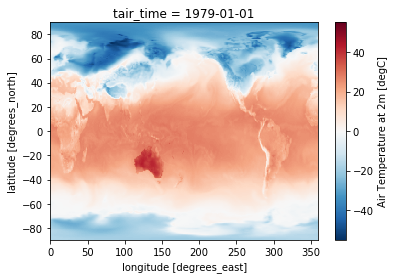

In [118]:
tair['Tair'].isel(tair_time=0).plot()
